In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import pickle
import random

from fastai.vision.all import *

#from datetime import datetime
#from scipy.signal import savgol_filter
#from scipy.signal import correlate

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [10]:
from IPython.core.magic import register_cell_magic
@register_cell_magic    # cells can be skipped by using '%%skip' in the first line
def skip(line, cell): return

In [11]:
from os import listdir
parquet_folder = r'C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\SIEGLEW_COPY\data\processed' # Trip parquet files
all_files = listdir(parquet_folder)

___

zu klärende Fragen:

1. Wie können die Tensoren für einzelne batches aufgeteilt werden?
    ---> werden die Zeitreihen eines batches einfach in einen Tensor aneinandergereiht?
    ---> oder werden {batch_size} Zeitreihen nacheinander eingegeben?
2. Gibt es besonders geeignete Transformationen für unsere Zeitreihen?


In [12]:
import torch
import torch.optim as optim

from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1);

In [13]:
print('Torch version: ', torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device(f"cuda:{torch.cuda.current_device()}") 
    #device = torch.device("cuda:0")   # or overwrite
    print(f'Current Device: {torch.cuda.current_device()},  Total Count: {torch.cuda.device_count()}')
else:
    device = ("cpu")

print(f"   --> Using {device} device")

Torch version:  2.3.1+cpu
Cuda available:  False
   --> Using cpu device


In [14]:
samples = ["v_id983V16_trip269.parquet", "v_id983V12_trip98.parquet", "v_id983V16_trip104.parquet", "v_id983V18_trip197.parquet", "v_id983V14_trip156.parquet", 
          "v_id983V18_trip197_2.parquet", "v_id983V18_trip201.parquet", "v_id983V16_trip58.parquet", "v_id983V17_trip86.parquet", "v_id983V13_trip180.parquet",
          "v_id983V14_trip157.parquet", "v_id983V14_trip89.parquet", "v_id983V14_trip220.parquet", "v_id983V18_trip227.parquet", "v_id983V14_trip232.parquet",
          "v_id983V18_trip251_2.parquet", "v_id983V13_trip210.parquet", "v_id983V18_trip223.parquet", "v_id983V10_trip62.parquet", "v_id983V13_trip23.parquet", 
          "v_id983V14_trip39.parquet", "v_id983V18_trip209.parquet", "v_id983V16_trip13.parquet", "v_id983V16_trip246.parquet", "v_id983V16_trip81.parquet"]

In [15]:
sample = random.sample(samples,1)
# sample = random.sample(all_files,1)
print(sample)

['v_id983V16_trip104.parquet']


In [16]:
for f in [sample[0]]:
    df = pd.read_parquet(parquet_folder + "/" + f, engine='fastparquet', 
                         columns = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", 
                                    "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", 
                                    "hv_batpwr_cval_bms1", "hv_batmomavldischrgen_cval_1"])

In [17]:
df.head()

,signal_time,hirestotalvehdist_cval_icuc,vehspd_cval_cpc,altitude_cval_ippc,bs_roadincln_cval,ambtemp_cval_pt,hv_batpwr_cval_bms1,hv_batmomavldischrgen_cval_1
0,1970-01-20 02:58:26.406451001,11621.205,0.0,68.75,1.0,19.5,-18.770,322.45
1,1970-01-20 02:58:26.407451001,11621.205,0.0,68.75,1.0,19.5,-18.785,322.45
2,1970-01-20 02:58:26.408451001,11621.205,0.0,68.75,1.0,19.5,-18.830,322.45
3,1970-01-20 02:58:26.409451001,11621.205,0.0,68.75,1.0,19.5,-18.810,322.45
4,1970-01-20 02:58:26.410451001,11621.205,0.0,68.75,1.0,19.5,-18.825,322.45


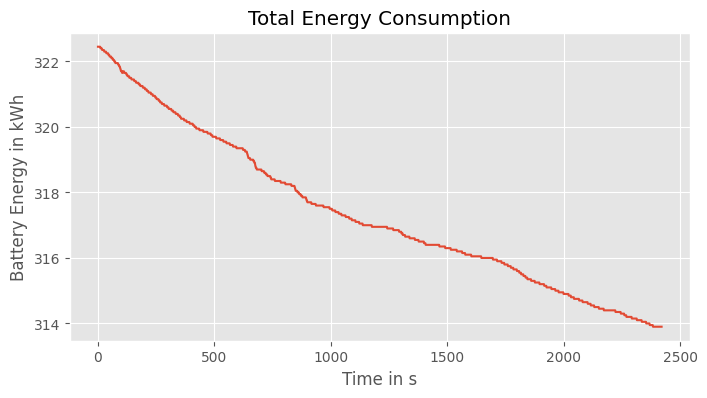

In [18]:
plt.style.use('ggplot')
plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')
df["hv_batmomavldischrgen_cval_1"].plot(label="CLOSE", title="Total Energy Consumption", figsize=(8,4));

In [19]:
# DATA NORMALIZATION -----------------------------------------------------------------
ss = StandardScaler()
mm = MinMaxScaler(feature_range=(0, 1))

X_ss = ss.fit_transform(df.iloc[:,1:-2])                # Standardize features by removing the mean and scaling to unit variance
y_mm = mm.fit_transform(pd.DataFrame(df.iloc[:,-1:]))   # Transform features by scaling each feature to a given range

print(f'StandardScaler: fitted with {ss.n_samples_seen_} samples.')
print(f'MinMaxScaler: fitted with {mm.n_samples_seen_} samples.')

StandardScaler: fitted with 2421 samples.
MinMaxScaler: fitted with 2421 samples.


In [20]:
# DATA SPLITS: TEST, TRAIN, VALIDATION ---------------------------------------------
# 
# # split sequence at 80 %:
n_train = round(len(X_ss) * 0.8)   # first n_train for training

# Train & Test Sets
X_train = X_ss[:n_train, :]#.to_numpy()
X_test = X_ss[n_train:, :]#.to_numpy()

y_train = y_mm[:n_train, :]#.to_numpy()
y_test = y_mm[n_train:, :]#.to_numpy()

In [21]:
# TENSOR CONVERSION -----------------------------------------------------------------
dtype = torch.float32
X_train_T = torch.tensor(X_train, dtype=dtype, requires_grad=True) # tensors
X_test_T = torch.tensor(X_test, dtype=dtype)

y_train_T = torch.tensor(y_train, dtype=dtype, requires_grad=True)
y_test_T = torch.tensor(y_test, dtype=dtype) 

In [22]:
# reshape
X_train_T_final = torch.reshape(X_train_T,   (X_train_T.shape[0], 1, X_train_T.shape[1]))
X_test_T_final = torch.reshape(X_test_T,  (X_test_T.shape[0], 1, X_test_T.shape[1]))

print("Training Shape", X_train_T_final.shape, y_train_T.shape)
print("Testing Shape", X_test_T_final.shape, y_test_T.shape)

Training Shape torch.Size([1937, 1, 5]) torch.Size([1937, 1])
Testing Shape torch.Size([484, 1, 5]) torch.Size([484, 1])


In [23]:
# Create TensorDataset for training and testing
train_dataset = TensorDataset(X_train_T_final, y_train_T)
test_dataset = TensorDataset(X_test_T_final, y_test_T)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the size of the datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 1937
Testing dataset size: 484


In [24]:
# LSTM NETWORK -----------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, seq_length, device = device, dtype = dtype):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.num_classes = num_classes  # number of classes
        self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            input_size = input_size,    # The number of expected features in the input x
            hidden_size = hidden_size,  # The number of features in the hidden state h
            num_layers = num_layers,    # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first = True,         # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias = True,                # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout = 0.0,              # usually: [0.2 - 0.5] , If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional = False,      # If True, becomes a bidirectional LSTM. Default: False
            proj_size = 0,              # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device = device, 
            dtype = dtype
            ) 
        
        self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)     # fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,input, batch_size = None):
        # initial hidden and internal states
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        

        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        
        return out

In [25]:
# CONFIGURATION -----------------------------------------------------------------

# Device --------------------------------
input_size = 5      # features
hidden_size = 12    # features in hidden state
num_layers = 1      # stacked lstm layers
num_classes = 1     # output classes 

# Hyperparameters --------------------------------
num_steps = 500 # 1000 epochs
learning_rate = 1e-3 # 0.001 lr

In [26]:
# INSTANTIATE MODEL -----------------------------------------------------------------
model = LSTM1(input_size, hidden_size, num_layers, num_classes, X_train_T_final.shape[1], device=device).to(device)

# Print model information
print(model)

print(f"\nModel state:")
for param_tensor in model.state_dict():
    print(f"{param_tensor}: \t{model.state_dict()[param_tensor].shape}")

LSTM1(
  (lstm): LSTM(5, 12, batch_first=True)
  (fc_1): Linear(in_features=12, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

Model state:
lstm.weight_ih_l0: 	torch.Size([48, 5])
lstm.weight_hh_l0: 	torch.Size([48, 12])
lstm.bias_ih_l0: 	torch.Size([48])
lstm.bias_hh_l0: 	torch.Size([48])
fc_1.weight: 	torch.Size([128, 12])
fc_1.bias: 	torch.Size([128])
fc.weight: 	torch.Size([1, 128])
fc.bias: 	torch.Size([1])


In [27]:
# OPTIMIZER -----------------------------------------------------------------
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),       # iterable of parameters to optimize or dicts defining parameter groups
    lr = learning_rate,       # learning rate (default: 1e-3)
    betas = (0.9, 0.95),      # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps = 1e-8,               # term added to the denominator to improve numerical stability (default: 1e-8)
    weight_decay = 1e-4       # weight decay coefficient (default: 1e-2)
)

In [28]:
# LOSS FUNCTION -----------------------------------------------------------------
def loss_func(model_output, target):
    criterion = F.mse_loss(model_output, target) # mean-squared error for regression
    return criterion

In [29]:
%%skip 

import wandb
wandb.init(project="first_project",     # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "epochs": num_steps,
    })

wandb.watch(model)

In [30]:
# TRAINING -----------------------------------------------------------------
train_losses = [] # collect loss
model.train() # set model to training mode

for step in range(num_steps):
  # -----------------------
  # forward pass, obtain loss function, apply backpropagation:

  loss = loss_func(model.forward(X_train_T_final) , y_train_T)
  loss.backward()

  # -----------------------
  # update model parameters and reset gradients:
  #nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) # optional: Gradient Value Clipping
  optimizer.step()
  optimizer.zero_grad()

  # -----------------------
  # print stats:
  if step % 50 == 0 or step == num_steps-1:
    print(f"Step: {step+1}/{num_steps}, loss: {loss.item():.6f}")
    
  # -----------------------
  #wandb.log({"loss": loss})
  train_losses.append(loss.item())

Step: 1/500, loss: 0.237828


Step: 51/500, loss: 0.028108
Step: 101/500, loss: 0.003964
Step: 151/500, loss: 0.002650
Step: 201/500, loss: 0.001907
Step: 251/500, loss: 0.001071
Step: 301/500, loss: 0.000786
Step: 351/500, loss: 0.000666
Step: 401/500, loss: 0.000601
Step: 451/500, loss: 0.000561
Step: 500/500, loss: 0.000533


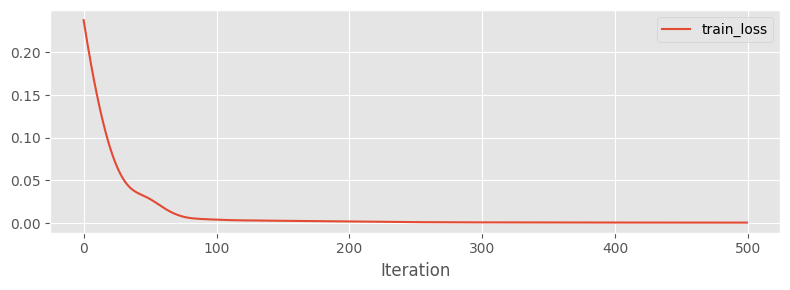

In [31]:
# plot training performance:
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlabel('Iteration')

plt.plot(train_losses, label='train_loss')
fig.tight_layout(); plt.legend();

In [32]:
# EVALUATION -----------------------------------------------------------------
model.eval()    # set model to evaluation mode
with torch.no_grad():
    test_loss = loss_func(model(X_test_T_final), y_test_T)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0696


In [33]:
# convert complete (scaled) input sequence to a tensor:
X_ss_T = torch.tensor(X_ss, dtype=dtype)

# reshape tensor for forwarding to model
X_ss_T = torch.reshape(X_ss_T, (X_ss_T.shape[0], 1, X_ss_T.shape[1]))

In [34]:
# Test with complete sequence
y_mm_pred = model(X_ss_T).data.cpu().numpy() # forward pass; outputs the predictions of the complete sequence

In [35]:
# reverse transformations using the MinMaxScaler from above:
y_pred = mm.inverse_transform(y_mm_pred) 
y_test = mm.inverse_transform(y_mm)

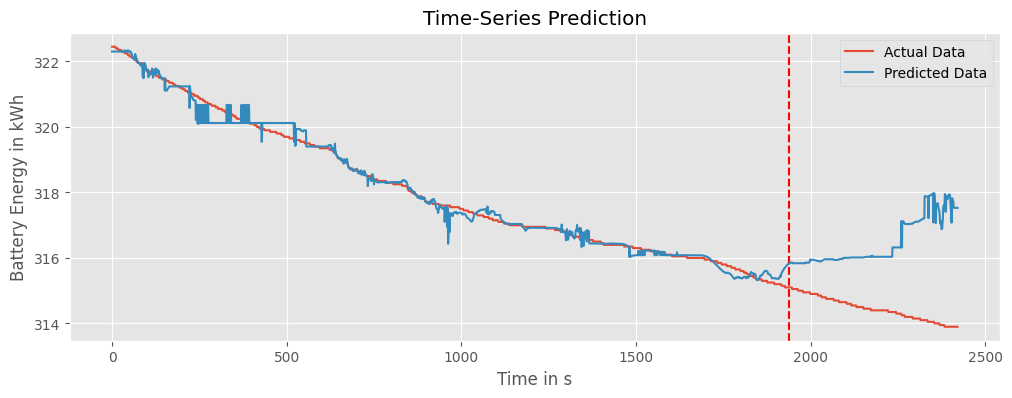

In [36]:
# PLOT RESULTS -----------------------------------------------------------------
plt.figure(figsize=(12,4)) 
plt.axvline(x=n_train, c='r', linestyle='--') # mark size of the training set

plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')

plt.plot(y_test, label='Actual Data') # actual plot
plt.plot(y_pred, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend();